# K-Means

## Data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from sklearn.datasets import make_blobs

In [5]:
X, Y = make_blobs(n_samples=500, n_features=2, centers=3)

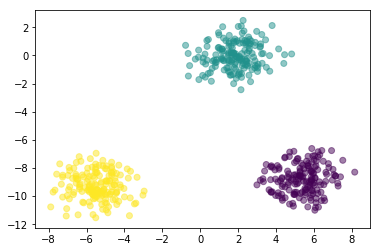

In [6]:
scatter(X[:,0], X[:,1], c=Y, alpha=0.5)

All of these clusters are Gaussian with isotropic covariance matrices ($\Sigma=\sigma^2 I$) and thay all have the same variance. This is the assumption of K-means, but K-means is still often used to initilaize density estimation when this is not the case. 

This is the pseudocode for K-means:


1. Let $K$ denote the number of clusters
2. Let $X$ denote the set of $N$ data points, each is an $M$-dimensional point. 
3. Set $\mu_1^{(0)}...\mu_k^{(0)}$ to $K$ randomly selected points from $X$
4. For $i=0, 1, 2, ...$ until convergence
5. &nbsp;&nbsp;&nbsp;&nbsp; 
      Set $d_{n,j}^{(i+1)} = ||X_n - \mu_j^{(i)}||^2$, the distance of each point to the nearest cluster center. 
6. &nbsp;&nbsp;&nbsp;&nbsp;  Set $c_n^{(i+1)}=\displaystyle{\arg\min_j d_{n,j}^{(i+1)}}$
7. &nbsp;&nbsp;&nbsp;&nbsp; 
      Set $\mu_c^{(i+1)} = \frac{\sum_{c_n=c} X_n }{\text{count}({c_n=c})}$
      
In order to test for convergence, you either test whether all $c_n^{(i+1)}=c_n^({i})$ or you can check whether $\sum_{c} \left(\mu_c^{(i+1)} - \mu_c^{(i)}\right)^2  < K\tau $ where $\tau$ is some tolerance parameter.  

Your first lab assignment is to implement k-means. My implementation is in `my_kmean` which I will load in the next cell. You can compare your results to mine. 
> NOTE: My implementation is not a perfect example of clear pythonic code, but you may look at it f you like.

In [7]:
%run -i my_kmeans

In [8]:
def kmeans(K, X, tolerance=0.001, mu_init=None, maxit=50):
    """ Do up to maxit iterations.
    Stop when the change is less than tolerance.
    Use mu_init to intialize mus, if it is None then randomly choose points
    Return cluster centetrs (mu), and cluster assignments (c)"""
    
    mus = mu_init
    if mus is None:
        mus = X[np.random.choice(len(X), K, replace=False)]
    
    distances = np.zeros((len(X), K))
    classes = np.zeros(len(X))
    for ind in range(maxit):
        # Calculate distances (This could be done in a more clever way)
        for i in range(len(X)):
            for j in range(K):
                distances[i][j] = np.linalg.norm(X[i] - mus[j])
        
        # Calculate classes
        classes = np.argmin(distances, axis=1)
        
        # Calculate mus
        next_mus = np.array([np.mean(X[np.where(classes == k)[0]], axis=0) for k in range(K)])
        
        # Check it tolerance is reached
        if np.sum(next_mus - mus)**2 >= K * tolerance:
            mus = next_mus
        else:
            break
    return mus, classes

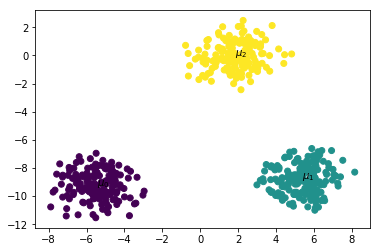

In [9]:
mus, clusters = kmeans(3, X)
scatter(X[:,0], X[:,1], c=clusters)
for k in range(len(mus)):
    text(mus[k,0], mus[k,1], r'$\mu_{}$'.format(k))

# EM-GMM: Expectation Maximization for Guassians

In [10]:
from sklearn.datasets import make_classification

In [20]:
X, Y = make_classification(n_samples=100, 
                           n_features=2,
                           n_redundant=0,
                           n_informative=2,
                           n_classes=2, 
                           n_clusters_per_class=1)

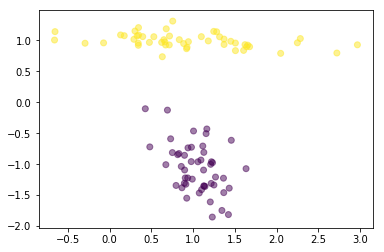

In [21]:
scatter(X[:,0], X[:,1], c=Y, alpha=0.5)

The EM GMM algorithm is similar to K-means, except that we use _soft_ memberships.
The probability $$w_{ij} = p(x_i=c_j) = \frac{\alpha_j N(x | \mu_m, \Sigma_j)}{\sum_m^K \alpha_j N(x | \mu_m, \Sigma_m)}$$ and the mixture weights $\alpha_j$ can be interpreted as the probability that a sample $x_i$ is generated by cluster $j$ out of a total of $K$ clusters. 

This means that the probability that $x_i$ came from the $j^{th}$ gaussian is
$c_{ij} = w_{ij}$.
Thus, $c_i = \arg\max_jc_{ij} = \arg\max_jw_{ij}$.

Then, using this information,  at each iteration we update the $w_{ij}, \alpha_j, \mu_j, \Sigma_j$ parameters as follows:
$$ w'_{ij} \text{as described above} $$
$$ \alpha'_j = \frac{\sum_{i=1}^{|\boldsymbol{x}|}w_{ij}}{|\boldsymbol{x}|}$$
$$ \mu'_j = \frac{\sum_{i=1}^{|\boldsymbol{x}|}w_{ij}x_{i}}{\sum_{i=1}^{|\boldsymbol{x}|}w_{ij}}$$
$$ \Sigma'_j = \frac{\sum_{i=1}^{|\boldsymbol{x}|}w_{ij}(x_i-\mu'_j)(x_i-\mu'_j)^T}{\sum_{i=1}^{|\boldsymbol{x}|}w_{ij}}$$

and so at each iteration we alternate between calculating $w_{ij}$ and than choosing $\alpha, \mu, \Sigma$ based on those. The process can stop with the change.

_Note: Referenced [these notes](http://www.ics.uci.edu/~smyth/courses/cs274/notes/EMnotes.pdf) which use slightly different terminology. In essence, $w_{ij}$ acts as $c_{ij}$ and $\alpha$ as $w$. I think it also describes the algorithm this way to stay closer to the general EM algorithm._

In [29]:
def gmm(x, mu, sigma):
    a = (2 * np.pi) ** (-x.shape[0] / 2.0) * np.linalg.det(sigma) ** -0.5
    exp = np.exp(-.5 * np.dot(x - mu, np.dot(np.linalg.inv(sigma), (x - mu).T)))
    return a * exp
                                                
def em_gmm(K, X, mus=None, sigmas=None, alphas=None, tolerance=0.001, maxit=50):
    if mus is None:
        mus = X[np.random.choice(len(X), K, replace=False)]
    
    if sigmas is None:
        sigmas = np.array([np.eye(X.shape[1]) for _ in range(K)])
        
    if alphas is None:
        alphas = np.array([1.0/K] * K)
    
    weights = np.zeros((X.shape[0], K))
    for ind in range(maxit):
        # E-Step #
        # Calculate weights
        for i in range(X.shape[0]):
            for j in range(K):
                weights[i][j] = alphas[j] * gmm(X[i], mus[j], sigmas[j])
        weights = (weights.T / np.sum(weights, axis=1)).T
        
        # M-Step #
        weights_k = np.sum(weights, axis=0)
        
        # Calculate mixture weights (alphas)
        new_alphas = weights_k / X.shape[0]
        
        # Calculate new mus
        new_mus = np.zeros((K, X.shape[0], X.shape[1]))
        for j in range(K):
            for i in range(X.shape[0]):
                new_mus[j][i] = np.dot(weights[i][j], X[i])
        new_mus = np.sum(new_mus, axis=1) / weights_k
        
        # Calculate new sigmas
        new_sigmas = np.zeros((K, X.shape[0], X.shape[1], X.shape[1]))
        for j in range(K):
            for i in range(X.shape[0]):
                x = np.reshape(X[i], (X.shape[1], 1))
                new_sigmas[j][i] = np.dot(np.dot(weights[i][j], x - new_mus[j]), (x - new_mus[j]).T)
        new_sigmas = np.sum(new_sigmas, axis=1) / weights_k
        
        # Check tolerance
        if np.sum(new_mus - mus)**2 >= K * tolerance:
            alphas = new_alphas
            mus = new_mus
            sigmas = new_sigmas
        else:
            break
    
    # Get most likely class for each X
    classes = np.argmax(weights, axis=1)
    
    return mus, classes

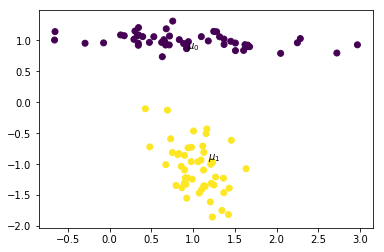

In [30]:
mus, clusters = em_gmm(2, X, np.array([[1.0, 2.0], [1.0, -2.0]]))
scatter(X[:,0], X[:,1], c=clusters)
for k in range(len(mus)):
    text(mus[k,0], mus[k,1], r'$\mu_{}$'.format(k))

_Note: I cheated somewhat and gave initial mu values to the EM-GMM model. It was not converging well under tolerance checking or maxiterations. I imagine tolerance checking is slightly different than K-means and should take into consideration a changing $\Sigma$ and a stationary $\mu$._